# Case Study

Domain –SEA Transportation

focus –forecast demand

Business challenge/requirement


SeaPort is the largest operator of Sea Planes across sea shores in Europe.  
SeaPort doesn't have planes of their own, rather they lease themon a short termbasis based on passenger traffic.

You as an ML expert have to builda model to forecast the demand (passenger traffic) of traffic. 

Key issuesAs of now utilization of Planes is low due to poor forecastsof traffic

ConsiderationsNONE

Data volume-Approx 144 records–data month wise for last 12 years –file SeaPlaneTravel.csv 

Fields in Data

•Month: Month in which traffic data was recorded 
    
•'#Passenger': No of travellers availing Service in that month
    
Additional information-NA

Business benefits

Better utilization of planes will lead to decrease in cost and hence better bottom line


In [1]:
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [2]:
df = pd.read_csv('SeaPlaneTravel.csv')
df.head()

,Month,#Passengers
0,2003-01,112
1,2003-02,118
2,2003-03,132
3,2003-04,129
4,2003-05,121


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
Month          144 non-null object
#Passengers    144 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.3+ KB


In [4]:
df['Date'] = pd.to_datetime(df['Month'])

In [5]:
df.head()

,Month,#Passengers,Date
0,2003-01,112,2003-01-01
1,2003-02,118,2003-02-01
2,2003-03,132,2003-03-01
3,2003-04,129,2003-04-01
4,2003-05,121,2003-05-01


In [6]:
df.tail()

,Month,#Passengers,Date
139,2015-08,606,2015-08-01
140,2015-09,508,2015-09-01
141,2015-10,461,2015-10-01
142,2015-11,390,2015-11-01
143,2015-12,432,2015-12-01


In [112]:
df['Year'] = df['Date'].dt.year

In [113]:
df.head()

,Month,#Passengers,Date,Year
0,2003-01,112,2003-01-01,2003
1,2003-02,118,2003-02-01,2003
2,2003-03,132,2003-03-01,2003
3,2003-04,129,2003-04-01,2003
4,2003-05,121,2003-05-01,2003


In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 4 columns):
Month          144 non-null object
#Passengers    144 non-null int64
Date           144 non-null datetime64[ns]
Year           144 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 4.6+ KB


In [132]:
df_sample = df[df['Year'] > 2005]

In [133]:
df_sample.head()

,Month,#Passengers,Date,Year
24,2006-01,145,2006-01-01,2006
25,2006-02,150,2006-02-01,2006
26,2006-03,178,2006-03-01,2006
27,2006-04,163,2006-04-01,2006
28,2006-05,172,2006-05-01,2006


In [134]:
df_data = df_sample[['Date','#Passengers']]

In [135]:
df_data.set_index('Date',inplace=True)

In [128]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 2003-01-01 to 2015-12-01
Data columns (total 1 columns):
#Passengers    144 non-null int64
dtypes: int64(1)
memory usage: 2.2 KB


In [136]:
df_data.head()

,#Passengers
Date,
2006-01-01,145
2006-02-01,150
2006-03-01,178
2006-04-01,163
2006-05-01,172


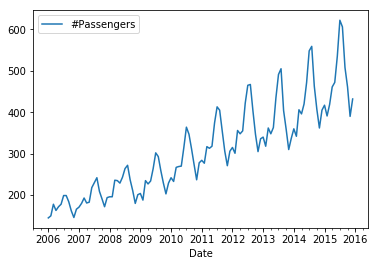

In [137]:
df_data.plot()

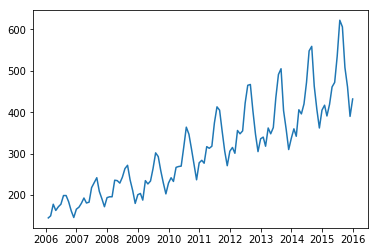

In [161]:
ts_month = df_data.resample('M').mean()
plt.plot(ts_month)

In [139]:
ts_month.head()

,#Passengers
Date,
2006-01-31,145
2006-02-28,150
2006-03-31,178
2006-04-30,163
2006-05-31,172


In [140]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(ts_month['#Passengers'])
result

(0.6488250087537084,
 0.9887592513504372,
 13,
 106,
 {'1%': -3.4936021509366793,
  '5%': -2.8892174239808703,
  '10%': -2.58153320754717},
 836.6781165871572)

In [141]:
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

for value,label in zip(result,labels):
    print(label+' : '+str(value) )
    
if result[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Augmented Dickey-Fuller Test:
ADF Test Statistic : 0.6488250087537084
p-value : 0.9887592513504372
#Lags Used : 13
Number of Observations Used : 106
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [159]:
ts_month['Lag1'] = ts_month['#Passengers'] - ts_month['#Passengers'].shift(1)
ts_month['Lag12'] = ts_month['#Passengers'] - ts_month['#Passengers'].shift(12)

In [145]:
ts_month_lag = ts_month['Lag1']

In [146]:
ts_month_lag.head()

Date
2006-01-31     NaN
2006-02-28     5.0
2006-03-31    28.0
2006-04-30   -15.0
2006-05-31     9.0
Freq: M, Name: Lag1, dtype: float64

In [148]:
ts_month_lag = ts_month_lag.dropna()

In [152]:
result = adfuller(ts_month['Lag1'].dropna())
result

(-2.455573518149467,
 0.12666123063966084,
 12,
 106,
 {'1%': -3.4936021509366793,
  '5%': -2.8892174239808703,
  '10%': -2.58153320754717},
 827.5375769998687)

In [153]:
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

for value,label in zip(result,labels):
    print(label+' : '+str(value) )
    
if result[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.455573518149467
p-value : 0.12666123063966084
#Lags Used : 12
Number of Observations Used : 106
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [160]:
result = adfuller(ts_month['Lag1'].dropna())
result

(-2.455573518149467,
 0.12666123063966084,
 12,
 106,
 {'1%': -3.4936021509366793,
  '5%': -2.8892174239808703,
  '10%': -2.58153320754717},
 827.5375769998687)

#### Since data became stationary for lag 1 hence differencing d =1

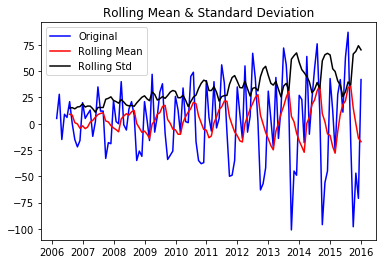

Results of Dickey-Fuller Test:
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 
Test Statistic                  -2.455574
p-value                          0.126661
#Lags Used                      12.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


In [254]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=6,center=False).mean() 
    rolstd = timeseries.rolling(window=6,center=False).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    if dftest[1] <= 0.05:
        print('P Value :',dftest[1],' <= ','Threshold Value : 0.05')
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    dfoutput.head()
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(ts_month_lag)

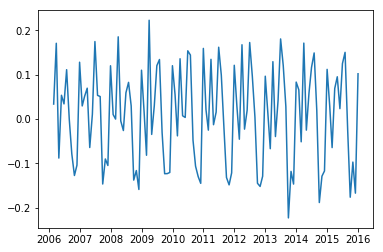

In [162]:
ts_month_log = np.log(ts_month)
ts_month_log_diff = ts_month_log - ts_month_log.shift()
plt.plot(ts_month_log_diff)

####ts_month_log_diff = ts_month_log_diff.replace([np.inf, -np.inf], np.nan).fillna(0)

In [255]:
month_log_diff = ts_month_log_diff['#Passengers']

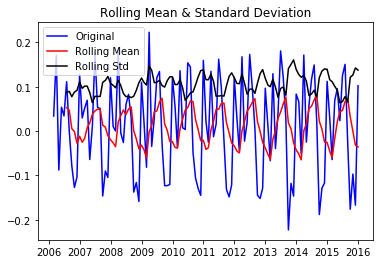

Results of Dickey-Fuller Test:
P Value : 0.03967376058742324  <=  Threshold Value : 0.05
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary
Test Statistic                  -2.951547
p-value                          0.039674
#Lags Used                      13.000000
Number of Observations Used    105.000000
Critical Value (1%)             -3.494220
Critical Value (5%)             -2.889485
Critical Value (10%)            -2.581676
dtype: float64


In [256]:
ts_month_log_diff.dropna(inplace=True)
test_stationarity(month_log_diff)

In [172]:
ts_month_log_diff.head()

,#Passengers
Date,
2006-02-28,0.033902
2006-03-31,0.171148
2006-04-30,-0.088033
2006-05-31,0.053744
2006-06-30,0.034289


In [173]:
#ACF and PACF
lag_acf = acf(ts_month_log_diff, nlags=10)
lag_pacf = pacf(ts_month_log_diff, nlags=10, method='ols')

Text(0.5,1,'Autocorrelation Function')

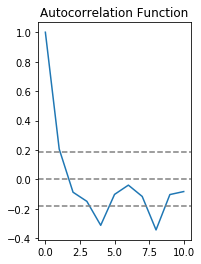

In [258]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-2/np.sqrt(len(ts_month_log_diff)),linestyle='--',color='gray')
plt.axhline(y=2/np.sqrt(len(ts_month_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

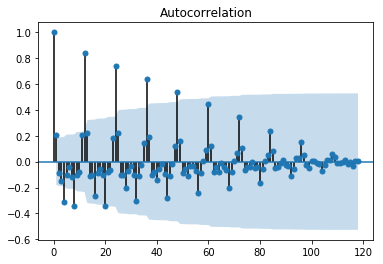

In [175]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(ts_month_log_diff.dropna())
plt.show()

#### ACF plot determines the Moving Avearge values MA(Q) which is the second highes value that croseses th threshold which is 1 in this case

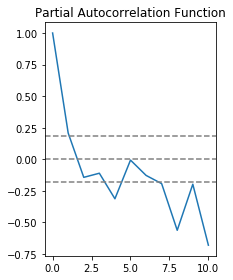

In [259]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-2/np.sqrt(len(ts_month_log_diff)),linestyle='--',color='gray')
plt.axhline(y=2/np.sqrt(len(ts_month_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

#### PACF gives the AR(P) value which is the point at which PACF will be zero p =1 in this case

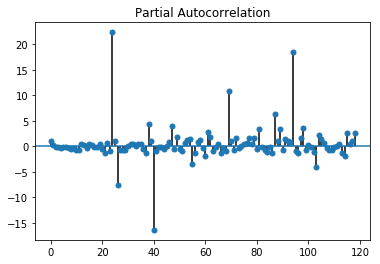

In [177]:
plot_pacf(ts_month_log_diff.dropna())
plt.show()

In [178]:
import warnings
warnings.filterwarnings("ignore")
model = ARIMA(ts_month_log, order=(2, 1, 1))  
results_ARIMA = model.fit()  


In [182]:
results_ARIMA.fittedvalues.head()

Date
2006-02-28    0.009449
2006-03-31    0.014656
2006-04-30    0.046556
2006-05-31   -0.050615
2006-06-30    0.008995
Freq: M, dtype: float64

In [183]:
ts_month_log_diff.head()

,#Passengers
Date,
2006-02-28,0.033902
2006-03-31,0.171148
2006-04-30,-0.088033
2006-05-31,0.053744
2006-06-30,0.034289


Text(0.5,1,'RSS: 0.9713')

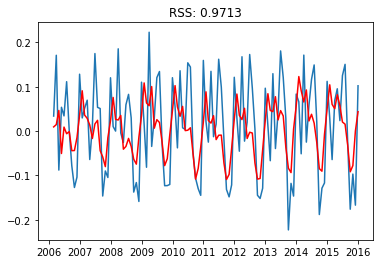

In [184]:
plt.plot(ts_month_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues - ts_month_log_diff['#Passengers'])**2))

                             ARIMA Model Results                              
Dep. Variable:          D.#Passengers   No. Observations:                  119
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 117.244
Method:                       css-mle   S.D. of innovations              0.089
Date:                Mon, 07 Jan 2019   AIC                           -224.487
Time:                        14:29:19   BIC                           -210.592
Sample:                    02-28-2006   HQIC                          -218.845
                         - 12-31-2015                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0094      0.001     17.184      0.000       0.008       0.011
ar.L1.D.#Passengers     1.0021      0.083     12.131      0.000       0.840       1.164
ar.L2.D.#Passeng

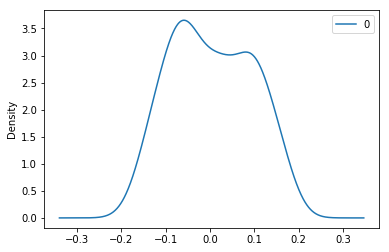

In [185]:
print(results_ARIMA.summary())
# plot residual errors
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())

In [272]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Date
2006-02-28    0.009449
2006-03-31    0.014656
2006-04-30    0.046556
2006-05-31   -0.050615
2006-06-30    0.008995
Freq: M, dtype: float64


Date
2006-02-28    0.009449
2006-03-31    0.024105
2006-04-30    0.070660
2006-05-31    0.020045
2006-06-30    0.029040
Freq: M, dtype: float64
Date
2006-01-31   NaN
2006-02-28   NaN
2006-03-31   NaN
2006-04-30   NaN
2006-05-31   NaN
Freq: M, Name: 2006-01-31 00:00:00, dtype: float64
Date
2006-01-31    0.000000
2006-02-28    0.009449
2006-03-31    0.024105
2006-04-30    0.070660
2006-05-31    0.020045
Freq: M, dtype: float64
Date
2006-01-31    1.000000
2006-02-28    1.009494
2006-03-31    1.024397
2006-04-30    1.073216
2006-05-31    1.020247
Freq: M, dtype: float64


Text(0.5,1,'RMSE: 327.1499')

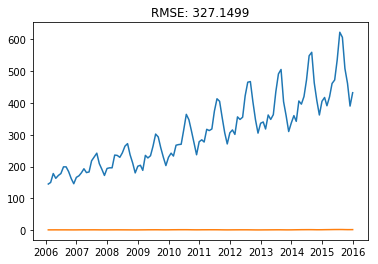

In [283]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())
predictions_ARIMA_log = pd.Series(ts_month_log.ix[0], index=ts_month_log.index)
print(predictions_ARIMA_log.head())
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0).fillna(0)
print(predictions_ARIMA_log.head())
predictions_ARIMA = np.exp(predictions_ARIMA_log)
print(predictions_ARIMA.head())
plt.plot(ts_month)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts_month['#Passengers'])**2)/len(ts_month)))

In [264]:
predictions_ARIMA_log.head()

Date
2006-01-31         NaN
2006-02-28    0.009449
2006-03-31    0.024105
2006-04-30    0.070660
2006-05-31    0.020045
Freq: M, dtype: float64

In [194]:
predictions_ARIMA.head()

Date
2006-01-31         NaN
2006-02-28    1.009494
2006-03-31    1.024397
2006-04-30    1.073216
2006-05-31    1.020247
Freq: M, dtype: float64

In [193]:
ts_month.head()

,#Passengers
Date,
2006-01-31,145
2006-02-28,150
2006-03-31,178
2006-04-30,163
2006-05-31,172


In [196]:
ts_month_log.head()

,#Passengers
Date,
2006-01-31,4.976734
2006-02-28,5.010635
2006-03-31,5.181784
2006-04-30,5.093750
2006-05-31,5.147494


In [198]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(predictions_ARIMA.fillna(0),ts_month))

327.153621743637

In [199]:
size = int(len(ts_month_log) - 12)
train, test = ts_month_log[0:size], ts_month_log[size:len(ts_month_log)]
history = [x for x in train]
predictions = list()

In [208]:
ts_month_log.head()

,#Passengers
Date,
2006-01-31,4.976734
2006-02-28,5.010635
2006-03-31,5.181784
2006-04-30,5.093750
2006-05-31,5.147494


predicted=6.085608, expected=6.146329
predicted=6.065888, expected=6.001415
predicted=5.928501, expected=5.849325
predicted=5.837980, expected=5.720312
predicted=5.771110, expected=5.817111
predicted=5.922541, expected=5.828946
predicted=5.894780, expected=5.762051
predicted=5.822942, expected=5.891644
predicted=5.978394, expected=5.852202
predicted=5.892423, expected=5.894403
predicted=5.948968, expected=6.075346
predicted=6.113295, expected=6.196444
predicted=6.171535, expected=6.224558
predicted=6.161029, expected=6.001415
predicted=5.933310, expected=5.883322
predicted=5.908414, expected=5.736572
predicted=5.807930, expected=5.820083
predicted=5.954829, expected=5.886104
predicted=5.984463, expected=5.834811
predicted=5.903223, expected=6.006353
predicted=6.098134, expected=5.981414
predicted=6.008948, expected=6.040255
predicted=6.072337, expected=6.156979
predicted=6.175508, expected=6.306275
predicted=6.286321, expected=6.326149
predicted=6.256112, expected=6.137727
predicted=6.

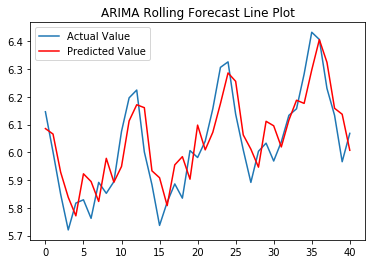

In [214]:
from sklearn.metrics import mean_squared_error
X = ts_month_log.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(2,1,1))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('\n-------------------------------------------------------------')
print('Test MSE : %.3f' % error)
print('\n-------------------------------------------------------------')
# plot
plt.plot(test,label='Actual Value')
plt.plot(predictions, color='red',label='Predicted Value')
plt.title('ARIMA Rolling Forecast Line Plot')
plt.legend()
plt.show()

In [211]:
len(test)

41

In [217]:
df_forecast = ts_month_log.iloc[-41:]

In [222]:
df_forecast['#Passengers'].count()

41

In [229]:
ypred = [x[0] for x in predictions]

In [230]:
ypred

[6.085607688624555,
 6.065888205066237,
 5.928501357372412,
 5.837980485698892,
 5.77111000507928,
 5.922540818241976,
 5.894780147060904,
 5.822942425455644,
 5.978393824475006,
 5.8924226708134855,
 5.9489682036033305,
 6.113295385056571,
 6.171535302052483,
 6.161028873596177,
 5.933309564396715,
 5.908413599038053,
 5.807929894742513,
 5.95482906000914,
 5.98446267426624,
 5.903222950417159,
 6.098134108017129,
 6.008947968879927,
 6.072337369516431,
 6.175507608451281,
 6.286320802248528,
 6.256112198766128,
 6.062728196765632,
 6.011543137022415,
 5.94656755595877,
 6.111861719716268,
 6.0956873803789255,
 6.019459650709238,
 6.116399323243724,
 6.1878193531983126,
 6.176466425356895,
 6.296753608934097,
 6.406239561720102,
 6.324486119026199,
 6.158769317797314,
 6.137328709516326,
 6.007399084102768]

In [231]:
df_forecast['#Passengers_forecast'] = ypred

In [232]:
df_forecast.head()

,#Passengers,#Passengers_forecast
Date,,
2012-08-31,6.146329,6.085608
2012-09-30,6.001415,6.065888
2012-10-31,5.849325,5.928501
2012-11-30,5.720312,5.837980
2012-12-31,5.817111,5.771110


In [284]:
df_forecast_scale_back = np.exp(df_forecast)

In [286]:
df_data.iloc[-41:].head()

,#Passengers
Date,
2012-08-01,467
2012-09-01,404
2012-10-01,347
2012-11-01,305
2012-12-01,336


In [285]:
df_forecast_scale_back.head()

,#Passengers,#Passengers_forecast
Date,,
2012-08-31,467.0,439.486803
2012-09-30,404.0,430.905240
2012-10-31,347.0,375.591215
2012-11-30,305.0,343.085774
2012-12-31,336.0,320.893729


In [291]:
print('RMSE for the forecasted model : ',np.sqrt(mean_squared_error(df_forecast['#Passengers'], df_forecast['#Passengers_forecast'])))

RMSE for the forecasted model :  0.0949195583886927


#### Since the RMSE value is close enough to 0 hence the model predictions are accurate

In [236]:
error = mean_squared_error(test, predictions)
print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)




Printing Mean Squared Error of Predictions...
Test MSE: 0.009010


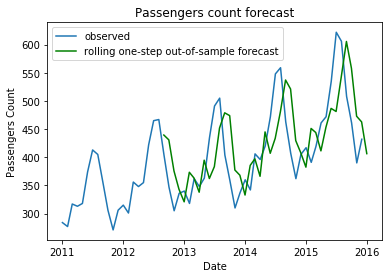

In [287]:
fig, ax = plt.subplots()
ax.set(title='Passengers count forecast', xlabel='Date', ylabel='Passengers Count')
ax.plot(df_data.iloc[-60:], '-', label='observed')
ax.plot(np.exp(df_forecast['#Passengers_forecast']), 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')